In [2]:
# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

     |████████████████████████████████| 51 kB 4.1 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=3e79b65ecab23f8941d433f03f9b41087f044ecdf53eae120afd3384e7d8fa56
  Stored in directory: /root/.cache/pip/wheels/22/52/02/b0f1baef4767ba74a977b80fff80ea7aff9a5d6468b3c1a900
Successfully built polytope
     |████████████████████████████████| 9.2 MB 6.7 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Un

In [3]:
from __future__ import division
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import polytope as pt
import pyomo.environ as pyo

## Problem 1

In [4]:
'''
DO NOT MODIFY THIS CELL!
'''

# model parameters
m = 27648
l = 70
J = 1 / 16 * m * l**2
g = 9.8

# state = (theta, omega, h, v)
# state constraints
tmin = -20 * np.pi / 180
tmax = 20 * np.pi / 180
zmin = np.array([tmin, -100, -3000, -100])
zmax = np.array([tmax, 100, 0, 500])

# input constraints
Fmax = 2 * 845 * 1000
dmax = 5 * np.pi / 180
umin_original = np.array([0, -dmax])
umax_original = np.array([Fmax, dmax])
Hu = np.array([[1, 0], [-1, 0], [-umax_original[1], 1], [umin_original[1], -1]])
Ku = np.array([umax_original[0], -umin_original[0], 0, 0])

# initial conditions
t0 = 15 * np.pi / 180
v0 = 205
alt0 = 1228
z0 = np.array([t0, 0, -alt0, v0])

# timestep
TS = 0.1

# model
A = np.array([[1, TS, 0, 0], [0, 1, 0, 0], [0, 0, 1, TS], [0, 0, 0, 1]])
B = np.array([[0, 0], [0, -TS / J * (l / 2)], [0, 0], [-TS / m, 0]])
f = np.array([0, 0, 0, TS * g])
nx = 4
nu = 2

# MPC
Q = 10 * np.eye(4)
R = 0 * np.eye(2)
P = 10  # NOTE: this is the MPC horizon, not the terminal cost weight

# length of simulation
N = 100

In [5]:
#@title # Run this cell to generate `falcon_traj.mat`
#@markdown *DO NOT MODIFY THIS CELL*

def _generate_data():
  data = b"""
  TUFUTEFCIDUuMCBNQVQtZmlsZSwgUGxhdGZvcm06IFBDV0lONjQsIENyZWF0ZWQgb246IFR1ZSBP
  Y3QgMzEgMTg6MTg6MjIgMjAxNyAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAg
  ICAAAAAAAAAAAAABSU0PAAAAcwUAAHicPdILNNRZGADwISl7FLVa0YNUWB1ED5TyTSrJOF7Jo8Zr
  KDSRdyHJK89lmGEwMYZolZ3SaaOki6LJI+Q9zWTVqlUstppSsX/HrXvud+753e/ee75z711OIpHO
  ypJIRCctJS2M820xtjQR3kRI4bnAM6HuYcQoRwQQi/Noi4Z2jgthOPtwn/KFUrhCbhAHuguBPjqp
  vW5tKZxgJ6cldA1BxZzhWrlaHrit330xzHwIut96qj935EHmhJ+n+e1BuK5jWZ47XQLJU44dE5qD
  UCPRUzPJLIHwg5P+Z9kDUJbT87VpSwlQrw8NDcsNQF1G+E2jx1zwf3uyUTuqH/yXtfOZ3lw4tJfT
  bPuuD1rXyJ8SkrhQc083w4XaB38OtVSt3lUMK1BCnXlHLxx2kn5qE1wEs0frviiY9cL6GNWN1MrL
  sP0Kb7qe3wMuBlQmeYQDLva1lnbqPWD7acXyWRUOvJ3eUdmS9QwCc6Kic+wKwSpYul5D6hnsyRpo
  k04pAGH0fX1aUDdkimjjFJQPm8buVqb81QX33R3bgyVs0NCSEebadcGSxJHjYXpsYHOdT6c1dMKy
  ob0Zjj55cE5XT8HXoBO8iji2Spxc6Jz2ErnuewomLroF1d0s4IjTw2o2dIBegIabgRwLJBYrDo6R
  2kGtuorBMGOC6GIef+pFK2iSpLf0hOVAnNhIqbP+CVztcNgwcy0b7iRG9yddFsCZh4N0mREGGFt7
  uSlHP4Z/rdtl3yszIIvtohDv2gJJhqf+EVhngUWYhX2rcTO0ObxRW74kE87BU19DE0PyN4ZozDk4
  A9K/zs1lCkzI/ewy74/CNNCfXfD42hBxzoFUuItNmznkbMBPhlnsEXnN7o7Vl0BzbsFs/Z8o9LhE
  AOzDez48knsXD/bYtoqvzSoc48AduzzuRe3+B7Hgiz0grDv50C4GArHfHW05NrcpCkKxWdpim12f
  IuAsto+01P6w1lCIxI5g6RvfKAqCKOzFm585972kQzR2rwOVTEk98SOfr/zt18atHj/2m3Jpm8/8
  4fDj/O2v+4SB47sh/Hs9q8xFw+KdKBhbVS3Ip83fHgVghzPpOcPr3JEfNmUbzyPyjQ+iYc+MRUfI
  7KMjKnZ68kaLFusg5Pi9fl6sfXpkKKJgZ67so9pVRCAy9iOtTX6/9ESiHd/vY+upUCEpBmlhn7/f
  a9aZG4uUsQ0qgx8Z6sYhGey2BHkrVlM8GsfvRw0p7ZS4JKJubGah0VHXySRUjV2rIRDWJSWjVOwK
  XWdPtXWpyAX74fCr0Yu30tAa7I/ugfRXlhnoybcFF3dIpg4O/4aOYwu0Htw7sjsLNeL/lhZ3cTZR
  loEGvizYe6k5+U4XA9nMLLhPsCjhDScbmUgWLN/f1Kzim4Mmx3HeLF7OahsTZQmtvgiqd5Cv/ryP
  Ej3LRHR+WYBlhiKZ5UnKrBKwkHazdCjjkiKZYlzfJWbmooEDS2RXpyiSFcqjlBQ98lBE1a2pRMI1
  NcZO5C1s9PsqnZcphPnnP+QHf2Qj1Q6OfwzhUanq56UN+Ug3wNopgvBzuwC13vQCxIzSnw4lnHFO
  x0vWuRAlUCr/nndkwmiZ0UYO2tC+MyWMcPF53mvfCQ6yda38b94hgW46BbWXkf/nmKp5i2mqp1sT
  itCeKUrE/H5T7z7+V5tipKJjpBlMuNLU8nPuMi6ivaxPCyBc5VhRoB/CRTW5+e5+hKdjF5s+HuCi
  7am31bwISxpoIo+9JehYd3GPE+FXaxpjPpeWIIlSMv8QYRZDXT1bjoe2ocb9BoTTNl9o0AnkoZbG
  I95yhD8MiryaenjIyYq78kayIrn8hqnM8V2l6OZEu5MoXZGscq3wyvviUvQ/5H5Rkw8AAAB+DAAA
  eJxtV3kwFfzXJ6FQlihbtpK9rq2uR/l+Q1SSshVlu8hyrxThZt/iIvt+E+WxpoSICt+va89jX1Mq
  ypKeJOtTll7PvL935n1n3s/MZz5zzpnz+eOcmTNzdjMxMY1wMTGxbekOpv/Wf8H6n3j7Fh23yPyf
  nPuNWza+W7pziw+2+iJ1p88KXmoBTP8bhGR87V8UuMD/qc+f/3KvZOoCMq4Ru/N1LAmnnZvW8mS4
  QJ+ndsvPTVqAc3viYNMrW7T6gKYfEJOEL/btmEx47wItizw8WQ1bQCCz/z7tN86oNpzKW0VMwtVF
  QlbolwvE3lkL/DotQMQojDTueAP1O4o8SZpMxAXuZiWbe11h5a7KvBX1FtBroSaRfeYWGniZ8Fkg
  KRF/efC5/7yqK6QEdKJX0i1g49Dt3X37qGj749kQLa1ETPZ7N/rUyBU+M5IN9OJrAb/HH3BTe/zQ
  hwuHjbhmE7DhnFaTJMUVbnaJiKmvN4OklFqxGM8gNPnNZG9QagJeC/uVnEdzhZJElgnOT83g79V3
  MmHBIShfRf9hGkzABMNZQ2K+K0wZkuPhbG0Gj/iQk8fxMCQ73+WZPxSPv3UMLr9rcIU6nNULOkXN
  YM6JaSHhWzjS2eQ2vaYQj53e34hPeu8Ke07Qh1sjmgHwVvV+lxyBhG0+ersHxeHx4itiFmuuUK/G
  m6eI1Axe/YgrMz5CQ7tLq91xXyyOuCNVQBAkQ3m3+IVlzWYQemHN5QeKQmK9K72XpWOx/OQJeSF1
  MnxXWDHE4GsG6jYS1OenYhCBOkMg+tzFLLp8pXzGZKhbKC0kMd0EyGMedTn4LprIahC3bovBFtzz
  avvdyfCpVIKQ+IsmcERKW66EEIemt+UqvxaMwdKJexjEu2T4oWb6j15aE7jb1lw9lBqPPtSk/PRz
  jsZ5o3mXHYvJkHjmyid98ybAWSGgwUNNQN2ZCRye1VH4fWn1Wm4LGW4e1fJPkWwCDWLGxxrFE9HO
  bupqKWsUlnYzKP3xiQzvpS3ebJttBEUxGs4sjERUZbzf5IgJDfutnfW8yEyB73TfqC6XNwLNjfVP
  3dZJqN9Ds2wxJxKvl901ZIhRoOCMipqiTyOIZXVol1lJQp2mgQ/XvkZgBdgHdI9ToMZb/pnAPxpB
  dUX/CQ5aMsq4HfRC71gEPvmw7dywBQWmbzNq3VxjgJMhZm7e/CnIWrs1eiDkDnZYZ/fx86HAlOhL
  5+peMUCWcXY0+V4KKvLqLMzrCMfDyXsaCKkUuBCvvtRxmwEKnAS6Z0RTkVzzz9zn/OFYtNRCabWC
  At+Uk7WOH2Vs7eet77eMVMRimrebwyoMcwWr1nf1UKB37MRj8R8N4Cmxd4DKnYayTuwNyM4LxW/3
  TnpVz1GgzIH+xshHDaDEMkc+OjgN7dwfHez5NQTv075vXs7lBonS5TsjSA0g935tj8TfaWgtRbGE
  phyCkwO8SLXybnAXQYBdUagB4BqK1HHjdKQ1Iho/5h2MXYuC5N4jCrzEXqgX04WBKjOb0VBFOhqr
  tOiuDQjC5lOB4IEIBZrKPHKsCsVgMYFm/n1XBpJeUfxrSSAQHz0YaEbyIcNZThJzrToGASFLxEj7
  DGR+6xm//XN/zEsKIB/sd4UOdgev23Uj0Pn1zMr9ZxnI/ci3InYbPzyb4x8yddgVTkmu659VRoA0
  Q4tT3dyqy4zSJrh9MWPML70o2gWeNep7bZZYD4jx5cyndTKRxVXfysU2KqaL+D1xnXKGM++VlAu/
  14HXq41Gb0MzkXxXp4JmtA++aeHbqKjtDMOaU6vsztUBbg1M/VabiT77D8zVmHhj/fTbb+buO8HT
  qwlJRYW1gOpS4B/4IxNFOsdtUKS9sNgg9XvZz2vwjVPBthzmWjCf7X0lToKO+BLXLl367YmX+Kis
  nmbXoB6HFXS2fAXezhEE9p+lo4gVkU2fcQ/cfsFHRL3cEQr3akbIVLwEe68PFstfp6NPGd+/d3Xc
  xDlx3sqrXI7QsrR9N9POl2CJ4CBUfZeOZKjeSlfrb2Cvv7z0Xzg7wMjkWH4BmxcAGIzZM/LpqFjW
  zg14uGMDDi8rvyZ7mH9zd19UZQ0g9sCocy/oaHBUc58q1Q1LnL7leULCHmpp9IeE7KwByX1xUWat
  dNTHFnA5OY6MV+54Rv32I0G7UZK1uHU18HNodRjrpqOcxweVbatccEejR07DsB0s0dXNjah4DhLS
  Z4U/99GR1l8qDzP/dsIPmT2qwlTtoL7TZuQo23Mw6f9PiUsPHT11LCwCatewD7jZcSreFi4RBM9q
  XakCrNI/9l1vo6Pv1FB947sOmP7rI4N7yAayJwgeGHxaCb7mDFj/eElHzGxNAb1LJKzn/WEuOdYa
  XveIMGRsrwScG7nBi4Vb8+OiGNS52eHFH2PCgqesYGXzDIuc5TNgYHA14FY8HR0WWbZVmLPBOW7v
  9LLWr0BWn5ZgxbIKwJHJZHbrJh0ReT5YVEla4XNfRj0kKi2himfB5ne2CiC0FM++aLjl/09qiKC3
  Jf7l8CY7j2wBywu4a9KsywHDhSN1/iAdKQ8KjZh+vYSLPg6/lj1wGeZv0KZ1qstAC9uNDcpKJpLI
  d7VyDTHDl64OrTweNYcf7TNbhXnLgNUwhs6MTFTmTOO1IJpgtpEBKeUkM9gWFS8dMFIKiNPr1hO0
  TPRJ3HNJgucirjbpP191xhT27TvKnp/4BISePHj57ZlM5J5qxhXOex47d/f6ajCbwHp9teJFw8fg
  4/xRRRPWTGTZZx1L1T2LhQ16CupqLsLpufTgp7tKgNdvtbdnXmWgqBVmivgLPdzV0tV38sYFKDlx
  fZt4bzH46C3miMgZ6CczKKK662D2O/SNGKPzsH255U9aRhEAtovtz/ZmoJIlAe1wJ4i9/NPNUuoN
  YPPGkzcqDoWA0PRsp0zt1n25v8szXFsTz3imPMlSOgPjO5WFHNQKQN8jm4NCV9NRsfiB/Y4aR7Ed
  OZE1P0sPEom2w6Sd+aBdZFUoeiUNpd6ghD56pownSHFWTzh14XUe/SivT38CLTHf2dsxaYhFov9U
  MUkBUyxjqqp8T8Jw2aU/Jxi5YLxmJnVGOA2NrKlttDgcxKx5PCL+/SfgbWOvrPnCh2D2h7boUF4q
  0v+ybnb1rSi+nMzRcbecCNdsRqYnkx4A8W5agLZcKqrjt8mu+8WHJ0K3+92PV4VvdM1XeHfkgF6z
  ly+UilLQP4sShfZGbDh58l8fRTg2uJIGV7PARPRwT7pkCvK11x36RFtGwy3zVQHpUrCVv/Te50U6
  aPX4yAhOTUbZvNx6hPxRxGbRrqBVyAOnctPnojczQBTvYPwMSzL6h4+psrf1at2rD81DnhkO9Yck
  u2/jfemgzbXqWDclCdl/KXdw8SXUF8X61nmvGiA+wg0ZPpgK6kNCXqr1JKJQ1wHhAZu96HTNT5qI
  qAaack8b56Img1MWGoJChxORmGW3bJS6BErL3h9Kuq6MkoKtkk7gRNC/+O6Cf0QCytMb1GapOICe
  Un4iFV0Ces08fkBZKAHsKBxpq62IR4py7EdHFw6hOamvfcUlh9GeQ7eZvrDFAuWlrvxAwzj0+LFY
  x/bt8qgsXWHjs4cCOlm474Dc7yiw3JtF1Bq7i0Y1h85WMRRRV6TeI097GeTVPBB2XDQShGlrh6zZ
  xaAH/jzct4SOIIXxtdlLnAdQV/30ynGbcEDWR0HP30YhpT/HKYHBBPTyHn9GsP1+pNsbeUG3PQTk
  ju9Rcz9LQ6csBYZTjisj6omFWoFhfuTkNdI+8jwQxPPCbOnSCKS+TZ203KCMsruLtne27kCfb2bw
  ZCv5gl3DOvVv2O6grvCxmJO8KsgcXLZ8xPS9vnRP/X6un17AR1k8JcY0DKllLHzcLa+C/iaFyHJV
  LWqlDVVnmot4gCfifeKa6SFoPTWwM4JDBU2ROs/bxXEBQ7cZC5KSG9CELxg994MQ3i6aJv1UGQX/
  LhBu9RMEXraNv7NHr4Fsu4DyQ6t+SI6Ts9uTTxnljz02F1uWBFLBY16vte3AX9nznNQ/qEiASbQ8
  Q5GAhgZl/zhPkwUxsTLCGQOXgdUCX1+T0y10+CI9Xm5SCWm8Nj01JUcAHTYRintLLgAj888su4Ju
  oHpZc5HUYnlkm3r16rVlNbDwUSrq1QFdIEVr137I5IIeD3vnBlMPIUqK0mXpg5ogZY6DZ0VPDRxz
  kTUTH7ZFDhIDCR84JNEZ0/Obs8MnwTEW3XZIFAHbQl8HyLJcRCtpLlEu3XtQxXrjV53G0//37/h/
  8F+KdETX
  """
  
  import base64 
  data = base64.b64decode(data) 
  with open('falcon_traj.mat', 'wb') as f:
    f.write(data)


_generate_data()
!md5sum falcon_traj.mat

8502d7df1feb2760eedd28c4e11875a7  falcon_traj.mat


In [6]:
# read the reference trajectory
import scipy.io
ref_traj = scipy.io.loadmat('falcon_traj.mat')
ref_traj['opt_z'].shape # (dimension of state, trajectory length) = (4, 101)

(4, 101)

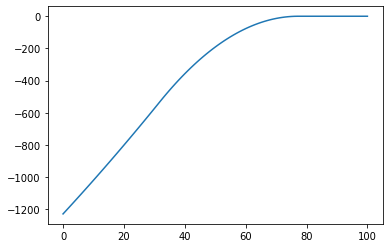

In [7]:
# plot what the reference trajectory looks like
plt.plot(ref_traj['opt_z'][2, :])
plt.show()

In [8]:
# Compute zref: closest to current state z, in height
# idx = np.argmax(ref_traj['opt_z'][2, :] >= z[2])
# zref = ref_traj['opt_z'][:, idx]

In [9]:
# Write your code
def solve_cftoc(A, B, f, P, Q, R, N, x0, xL, xU, uL, uU, xref):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)

    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    
    model.f = f
    model.xref = xref

    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX)
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += (model.x[i, t] - model.xref[i, t]) * model.Q[i, j] * (model.x[j, t] - model.xref[j, t]) 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += (model.u[i, t]) * model.R[i, j] * (model.u[j, t])
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += (model.x[i, model.N] - model.xref[i, model.N]) * model.P[i, j] * (model.x[j, model.N] - model.xref[j, model.N])
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense=pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX)
                               + model.f[i]) == 0.0 if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    model.init_const3 = pyo.Constraint(expr = model.x[2, 0] == x0[2])
    model.init_const4 = pyo.Constraint(expr = model.x[3, 0] == x0[3])


    model.upper_state_limit = pyo.Constraint(model.xIDX,
                                      model.tIDX,
                                      rule=lambda model, i, t: model.x[i, t] <= xU[i]
                                      if t <= N else pyo.Constraint.Skip)
    model.lower_state_limit = pyo.Constraint(model.xIDX,
                                      model.tIDX,
                                      rule=lambda model, i, t: model.x[i, t] >= xL[i]
                                      if t <= N else pyo.Constraint.Skip)
    
    model.lower_input_limit = pyo.Constraint(model.uIDX,
                                      model.tIDX,
                                      rule=lambda model, i, t: model.u[i, t] <= uU[i]
                                      if t <= N else pyo.Constraint.Skip)
    model.upper_input_limit = pyo.Constraint(model.uIDX,
                                      model.tIDX,
                                      rule=lambda model, i, t: model.u[i, t] >= uL[i]
                                      if t <= N else pyo.Constraint.Skip)  
    
            
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, uOpt, JOpt]

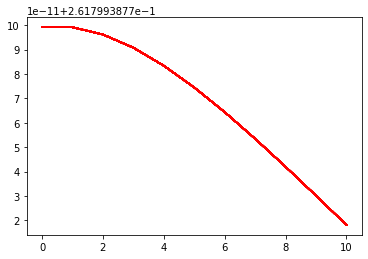

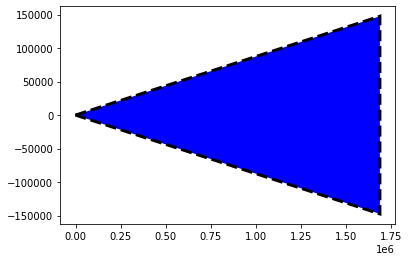

In [10]:
#Re-define Q & R
Q = np.diagflat([[1,1],[20,100]])

zref = ref_traj['opt_z']

nx = np.size(A, 0)
nu = np.size(B, 1)

xOptn = np.zeros((nx, N+1))
uOptn = np.zeros((nu, N))
xOptn[:, 0] = z0.reshape(nx, )

# fig = plt.figure(figsize=(9, 6))
for t in range(N):
    [model, feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, f, Q, Q, R, P, z0, zmin, zmax, umin_original, umax_original, zref)
    
    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOptn[:, t+1] = xOpt[:, 1]
    uOptn[:, t] = uOpt[:, 0].reshape(nu, )

    # Plot
    theta = plt.plot(xOpt[0,:], 'r-')
    # omega = plt.plot(xOpt[1,:], 'r-')
    # h = plt.plot(xOpt[2,:], 'r-')
    # v = plt.plot(xOpt[3,:], 'r-')

# tt = np.linspace(0,N+1,11)

# line2 = plt.plot(tt, xOpt[1, :], 'bo-')
# plt.legend([theta[0], line2[0]], ['Open-loop', 'Closed-loop']);
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.axis('equal')
# plt.show()
# plot results
# theta = [pyo.value(model.z[0,0])]
# omega = [pyo.value(model.z[1,0])]
# h = [pyo.value(model.z[2,0])]
# v = [pyo.value(model.z[3,0])]
# F = [pyo.value(model.u[0,0])]
# delta = [pyo.value(model.u[1,0])]

# for t in model.tidx:
#     if t < N:
#         theta.append(pyo.value(model.z[0,t+1]))
#         omega.append(pyo.value(model.z[1,t+1]))
#         h.append(pyo.value(model.z[2,t+1]))
#         v.append(pyo.value(model.z[3,t+1]))
#     if t < N-1:
#         F.append(pyo.value(model.u[0,t+1]))
#         delta.append(pyo.value(model.u[1,t+1]))

# t = np.linspace(0,N*Ts,101)
# t2 = np.linspace(0,N*Ts,100)

# fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(10, 10))

# ax[0].plot(t, theta)
# ax[0].set_ylabel('Rocket Angle[deg]')
# ax[0].set_xlabel('Time[s]')
# ax[1].plot(t, omega)
# ax[1].set_ylabel('Angular Velocity[deg/s]')
# ax[1].set_xlabel('Time[s]')
# ax[2].plot(t, h)
# ax[2].set_ylabel('Height[m]')
# ax[2].set_xlabel('Time[s]')
# ax[3].plot(t, v)
# ax[3].set_ylabel('Velocity[m/s]')
# ax[3].set_xlabel('Time[s]')

# ax[4].plot(t2, F)
# ax[4].set_ylabel('Force[N]')
# ax[4].set_xlabel('Time[s]')
# ax[5].plot(t2, delta)
# ax[5].set_ylabel('Thrust Angle[deg]')
# ax[5].set_xlabel('Time[s]')

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=1.3, 
#                     wspace=0.4, 
#                     hspace=0.4)
# plt.show()



# constraint sets represented as polyhedra


U = pt.Polytope(Hu,Ku)

fig, ax = plt.subplots()
U.plot(ax, color='b')
ax.autoscale_view()
plt.show()